In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

In [2]:
# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Ollama API configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)


## 1. Load Dataset

In [3]:
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})
print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


## 2. Tree-of-Thought Prompt Design

**Multi-Path Reasoning**:
- Path 1: Consider "positive" hypothesis
- Path 2: Consider "negative" hypothesis  
- Path 3: Consider "neutral" hypothesis
- Evaluation: Score each path's evidence strength
- Selection: Choose the most supported hypothesis

In [4]:
def create_tot_prompt(sentence):
    """
    Creates a Tree-of-Thought prompt with multi-path exploration.
    """
    prompt = f"""You are a financial sentiment analysis expert. Analyze this statement using a tree-of-thought approach.

Financial Statement:
"{sentence}"

TASK: Explore three possible sentiment classifications and select the best one.

---
PATH 1: Hypothesis = POSITIVE
Consider if this statement represents positive news for investors.
- What evidence supports this being positive?
- What evidence contradicts this being positive?
- Confidence score (0-1) for this hypothesis:

PATH 2: Hypothesis = NEGATIVE ⚠️
Consider if this statement represents FINANCIAL DETERIORATION for investors.
Look specifically for: losses, declines, revenue drops, margin compression, layoffs, failed ventures, widening losses, falling sales, cost increases, debt problems.
- What evidence supports this being negative?
- What evidence contradicts this being negative?
- Confidence score (0-1) for this hypothesis:

PATH 3: Hypothesis = NEUTRAL
Consider if this statement has no clear market impact.
- What evidence supports this being neutral?
- What evidence contradicts this being neutral?
- Confidence score (0-1) for this hypothesis:

---
FINAL DECISION:
Based on evaluating all three paths, select the hypothesis with the strongest evidence.
Provide ONLY this JSON format (no markdown, no extra text):
Provide your final answer in this exact JSON format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Explanation of why this hypothesis was selected over the others",
    "path_scores": {{
        "positive": 0.0-1.0,
        "negative": 0.0-1.0,
        "neutral": 0.0-1.0
    }}
}}
"""
    return prompt


# Test prompt
test_sentence = (
    "The company reported mixed results with revenue up 10% but margins declining."
)
print("=" * 80)
print("TREE-OF-THOUGHT PROMPT EXAMPLE")
print("=" * 80)
print(create_tot_prompt(test_sentence))

TREE-OF-THOUGHT PROMPT EXAMPLE
You are a financial sentiment analysis expert. Analyze this statement using a tree-of-thought approach.

Financial Statement:
"The company reported mixed results with revenue up 10% but margins declining."

TASK: Explore three possible sentiment classifications and select the best one.

---
PATH 1: Hypothesis = POSITIVE
Consider if this statement represents positive news for investors.
- What evidence supports this being positive?
- What evidence contradicts this being positive?
- Confidence score (0-1) for this hypothesis:

PATH 2: Hypothesis = NEGATIVE ⚠️
Consider if this statement represents FINANCIAL DETERIORATION for investors.
Look specifically for: losses, declines, revenue drops, margin compression, layoffs, failed ventures, widening losses, falling sales, cost increases, debt problems.
- What evidence supports this being negative?
- What evidence contradicts this being negative?
- Confidence score (0-1) for this hypothesis:

PATH 3: Hypothesis = 

## 3. Model Inference Functions

In [14]:
def call_ollama(prompt, model_name, temperature=0.0):
    """Call Ollama API for LLM inference"""
    max_retries = 3
    last_error = None
    
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_API_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "stream": False,
                    "temperature": temperature,
                },
                timeout=150,
            )
            
            if response.status_code == 200:
                result = response.json()
                return result.get("response", "")
            else:
                last_error = f"HTTP {response.status_code}"
                
        except Exception as e:
            last_error = str(e)
            print(f"Attempt {attempt + 1}/{max_retries} failed: {last_error}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            return None
    
    return None


def parse_response(response_text):
    """Parse JSON with path scores from ToT response"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "{" in response_text:
            start = response_text.find("{")
            end = response_text.rfind("}") + 1
            json_str = response_text[start:end]
        else:
            json_str = response_text.strip()

        result = json.loads(json_str)
        return result
        
    except Exception as e:
        # Fallback: try to extract sentiment with text matching
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
                "path_scores": {},
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
                "path_scores": {},
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
                "path_scores": {},
            }
        return None


print("✓ Model inference functions defined")

✓ Model inference functions defined


## 4. Run Experiments

### E10: Llama3.1:8b (Tree-of-Thought)

In [ ]:
# Run on full dataset for comprehensive evaluation
test_df = df.head(200).copy()

# E10: Llama3.1:8b (Tree-of-Thought)
print("Running E10: Llama3.1:8b (Tree-of-Thought)...")
e10_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E10 Progress"):
    prompt = create_tot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e10_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                    "path_scores": str(parsed.get("path_scores", {})),
                    "full_response": response[:700],
                }
            )
        else:
            e10_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                    "path_scores": "{}",
                    "full_response": response[:700] if response else "",
                }
            )
    time.sleep(0.1)

e10_df = pd.DataFrame(e10_results)
print(f"\n✓ E10 completed: {len(e10_df)} predictions")
display(e10_df.head())

Running E10: Llama3.1:8b (Tree-of-Thought)...


E10 Progress: 100%|██████████| 200/200 [1:03:23<00:00, 19.02s/it] 


✓ E10 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale,path_scores,full_response
0,"According to Gran , the company has no plans t...",neutral,positive,0.8,The statement indicates that the company is gr...,"{'positive': 0.8, 'negative': 0.1, 'neutral': ...","{\n ""sentiment"": ""positive"",\n ""confiden..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.9,The statement shows significant improvement in...,"{'positive': 0.9, 'negative': 0.05, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.9,The statement mentions a significant increase ...,"{'positive': 0.9, 'negative': 0.1, 'neutral': ...","{\n ""sentiment"": ""positive"",\n ""confiden..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.9,The statement reports an increase in operating...,"{'positive': 0.9, 'negative': 0.05, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.9,The statement indicates an increase in operati...,"{'positive': 0.9, 'negative': 0.05, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."


### E11: Qwen3:8b (Tree-of-Thought)

In [7]:
# E11: Qwen3:8b (Tree-of-Thought)
print("\nRunning E11: Qwen3:8b (Tree-of-Thought)...")
e11_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E11 Progress"):
    prompt = create_tot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e11_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                    "path_scores": str(parsed.get("path_scores", {})),
                    "full_response": response[:700],
                }
            )
        else:
            e11_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                    "path_scores": "{}",
                    "full_response": response[:700] if response else "",
                }
            )
    time.sleep(0.1)

e11_df = pd.DataFrame(e11_results)
print(f"\n✓ E11 completed: {len(e11_df)} predictions")
display(e11_df.head())


Running E11: Qwen3:8b (Tree-of-Thought)...


E11 Progress:  26%|██▌       | 51/200 [33:42<1:30:03, 36.26s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)


E11 Progress:  30%|███       | 60/200 [40:06<1:22:38, 35.42s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)
Attempt 2/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)


E11 Progress:  35%|███▌      | 70/200 [48:25<1:20:41, 37.24s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)
Attempt 2/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)


E11 Progress:  36%|███▌      | 71/200 [51:28<2:54:10, 81.01s/it]

Attempt 3/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)


E11 Progress:  37%|███▋      | 74/200 [53:15<1:47:16, 51.08s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)


E11 Progress: 100%|██████████| 200/200 [2:56:21<00:00, 52.91s/it]   


✓ E11 completed: 199 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale,path_scores,full_response
0,"According to Gran , the company has no plans t...",neutral,neutral,0.70,The statement provides information about produ...,"{'positive': 0.6, 'negative': 0.3, 'neutral': ...","{\n ""sentiment"": ""neutral"",\n ""confidenc..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.90,The statement highlights significant growth in...,"{'positive': 0.9, 'negative': 0.3, 'neutral': ...","{\n ""sentiment"": ""positive"",\n ""confiden..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement shows significant growth in both...,"{'positive': 0.95, 'negative': 0.1, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,The statement highlights a significant increas...,"{'positive': 0.95, 'negative': 0.2, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The statement shows a clear increase in operat...,"{'positive': 0.95, 'negative': 0.2, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."


### E12: DeepSeek-R1:8b (Tree-of-Thought)

In [15]:
# E12: DeepSeek-R1:8b (Tree-of-Thought)
print("\nRunning E12: DeepSeek-R1:8b (Tree-of-Thought)...")
e12_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E12 Progress"):
    prompt = create_tot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e12_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                    "path_scores": str(parsed.get("path_scores", {})),
                    "full_response": response[:700],
                }
            )
        else:
            e12_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                    "path_scores": "{}",
                    "full_response": response[:700] if response else "",
                }
            )
    time.sleep(0.1)

e12_df = pd.DataFrame(e12_results)
print(f"\n✓ E12 completed: {len(e12_df)} predictions")
display(e12_df.head())


Running E12: DeepSeek-R1:8b (Tree-of-Thought)...


E12 Progress:  42%|████▎     | 85/200 [1:25:35<1:51:05, 57.96s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=150)


E12 Progress:  56%|█████▋    | 113/200 [1:53:36<1:13:53, 50.96s/it]

Attempt 1/3 failed: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=150)


E12 Progress: 100%|██████████| 200/200 [3:34:00<00:00, 64.20s/it]  


✓ E12 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale,path_scores,full_response
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,"The statement indicates growth in Russia, whic...","{'positive': 0.6, 'negative': 0.2, 'neutral': ...","{\n ""sentiment"": ""neutral"",\n ""confidenc..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.75,The statement highlights a doubling of net sal...,"{'positive': 0.75, 'negative': 0.2, 'neutral':...","{\n ""sentiment"": ""positive"",\n ""confiden..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.90,The statement reports significant growth in bo...,"{'positive': 0.9, 'negative': 0.1, 'neutral': ...","```json\n{\n ""sentiment"": ""positive"",\n ..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.70,The operating profit increased from EUR 8.7 mi...,"{'positive': 0.7, 'negative': 0.1, 'neutral': ...","{\n ""sentiment"": ""positive"",\n ""confiden..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The statement shows a clear year-over-year inc...,"{'positive': 0.95, 'negative': 0.05, 'neutral'...","```json\n{\n ""sentiment"": ""positive"",\n ..."


## 5. Calculate Metrics

In [16]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_true, y_pred),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
e10_metrics, e10_cm, e10_valid = calculate_metrics(e10_df, "E10: Llama3.1:8b (ToT)")
e11_metrics, e11_cm, e11_valid = calculate_metrics(e11_df, "E11: Qwen3:8b (ToT)")
e12_metrics, e12_cm, e12_valid = calculate_metrics(e12_df, "E12: DeepSeek-R1:8b (ToT)")

# Create metrics comparison table
metrics_df = pd.DataFrame([e10_metrics, e11_metrics, e12_metrics])

print("\n" + "=" * 80)
print("TREE-OF-THOUGHT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall", "MCC"]
    ].round(4)
)


TREE-OF-THOUGHT PERFORMANCE COMPARISON


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall,MCC
0,E10: Llama3.1:8b (ToT),0.980,0.6616,0.9899,0.6000,0.4427
1,E11: Qwen3:8b (ToT),0.995,0.9432,0.9974,0.9000,0.8921
2,E12: DeepSeek-R1:8b (ToT),0.920,0.6454,0.6025,0.8615,0.3850


## 6. Visualize Results

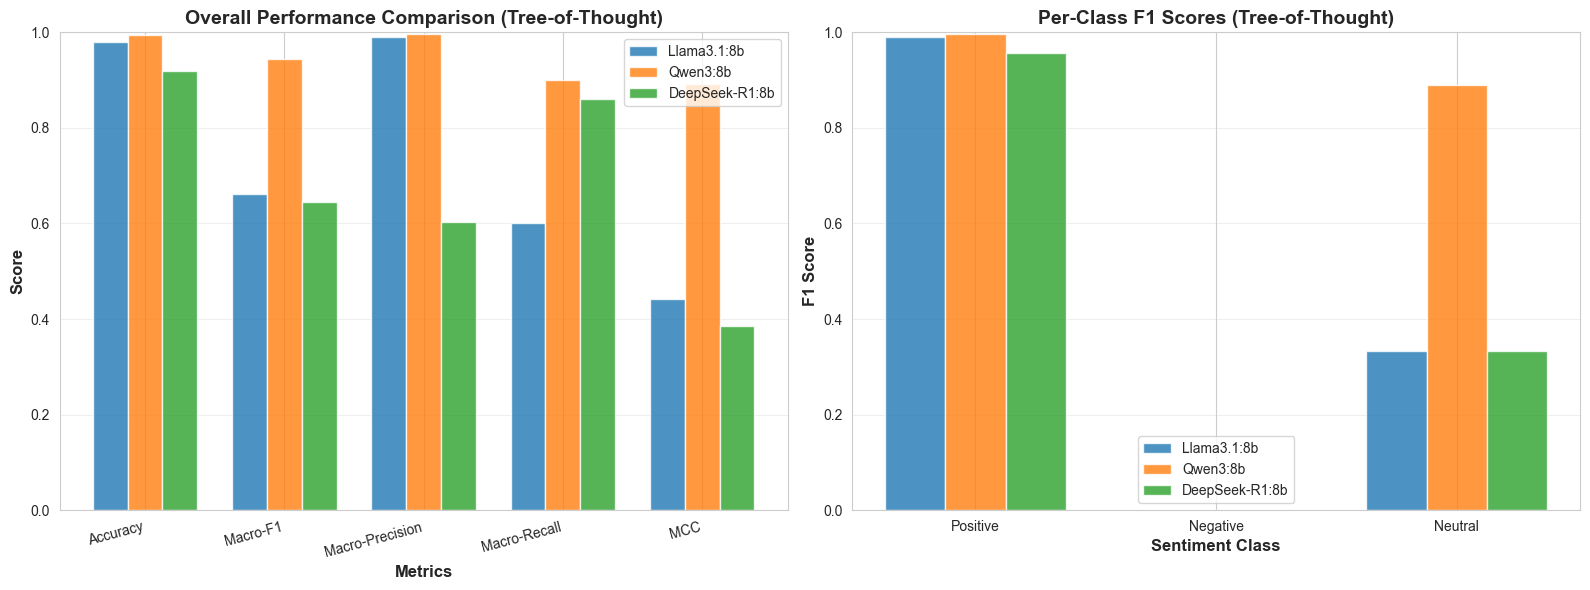

In [17]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall", "MCC"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e10_metrics, "Llama3.1:8b"),
        (e11_metrics, "Qwen3:8b"),
        (e12_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Tree-of-Thought)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=15, ha="right")
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e10_metrics, "Llama3.1:8b"),
        (e11_metrics, "Qwen3:8b"),
        (e12_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Tree-of-Thought)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("tot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

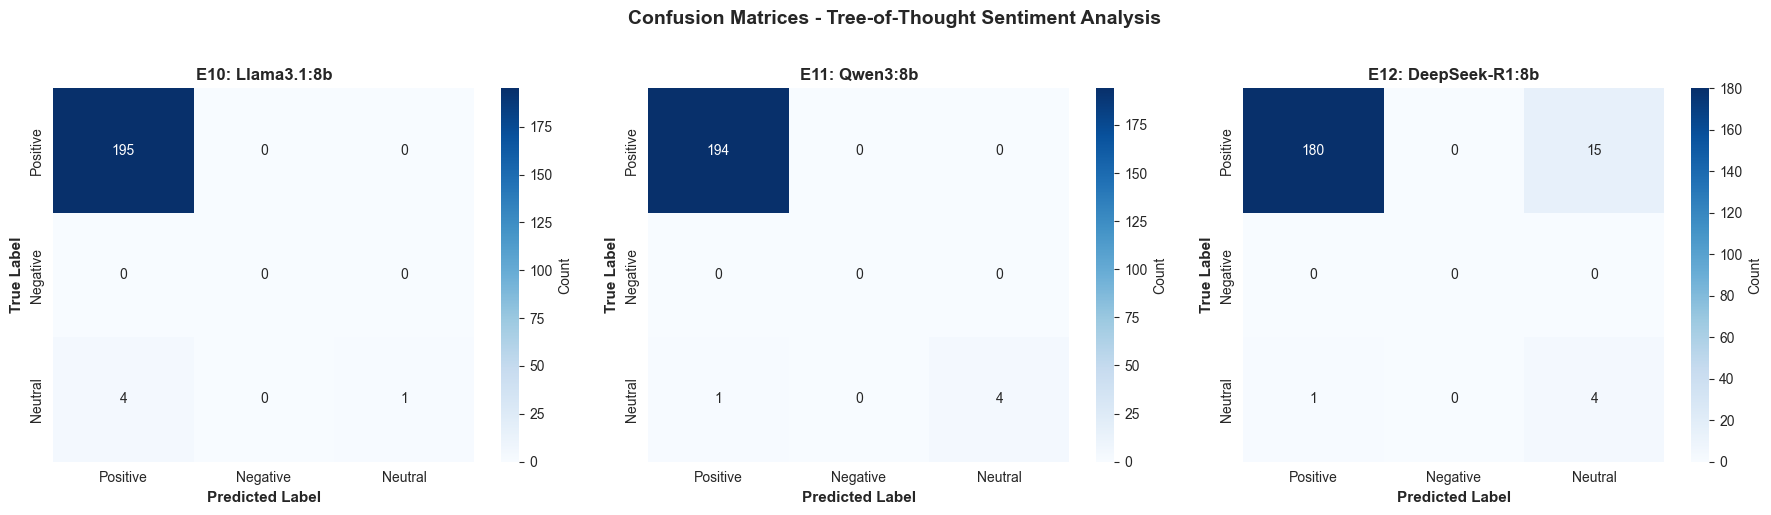

In [18]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e10_cm, "E10: Llama3.1:8b"),
        (e11_cm, "E11: Qwen3:8b"),
        (e12_cm, "E12: DeepSeek-R1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Tree-of-Thought Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Save Results

In [19]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

e10_df.to_csv(f"e10_llama3.1_8b_tot_{timestamp}.csv", index=False)
e11_df.to_csv(f"e11_qwen3_8b_tot_{timestamp}.csv", index=False)
e12_df.to_csv(f"e12_deepseek_r1_8b_tot_{timestamp}.csv", index=False)
metrics_df.to_csv(f"tot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - e10_llama3.1_8b_tot_{timestamp}.csv")
print(f"  - e11_qwen3_8b_tot_{timestamp}.csv")
print(f"  - e12_deepseek_r1_8b_tot_{timestamp}.csv")
print(f"  - tot_metrics_summary_{timestamp}.csv")
print(f"  - tot_performance_comparison.png")
print(f"  - tot_confusion_matrices.png")
print(f"  - tot_confidence_analysis.png")


✓ Results saved with timestamp: 20260212_114734

Files created:
  - e10_llama3.1_8b_tot_20260212_114734.csv
  - e11_qwen3_8b_tot_20260212_114734.csv
  - e12_deepseek_r1_8b_tot_20260212_114734.csv
  - tot_metrics_summary_20260212_114734.csv
  - tot_performance_comparison.png
  - tot_confusion_matrices.png
  - tot_confidence_analysis.png


## 8. Error Analysis

In [20]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (e10_valid, "E10: Llama3.1:8b"),
    (e11_valid, "E11: Qwen3:8b"),
    (e12_valid, "E12: DeepSeek-R1:8b"),
]:
    print(f"\n{exp_name}:")
    errors = df_result[df_result["true_sentiment"] != df_result["predicted_sentiment"]]

    # Count confusion pairs
    confusion_pairs = errors.groupby(["true_sentiment", "predicted_sentiment"]).size()
    print(f"Total Errors: {len(errors)}")
    print("\nMost Common Misclassifications:")
    for (true_label, pred_label), count in (
        confusion_pairs.sort_values(ascending=False).head(5).items()
    ):
        print(f"  {true_label} → {pred_label}: {count} errors")

    # Show sample errors
    print(f"\nSample Misclassified Sentences:")
    for idx, row in errors.head(3).iterrows():
        print(f"\n  Sentence: {row['sentence'][:100]}...")
        print(
            f"  True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Confidence: {row['confidence']:.3f}"
        )

ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS

E10: Llama3.1:8b:
Total Errors: 4

Most Common Misclassifications:
  neutral → positive: 4 errors

Sample Misclassified Sentences:

  Sentence: According to Gran , the company has no plans to move all production to Russia , although that is whe...
  True: neutral | Predicted: positive | Confidence: 0.800

  Sentence: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja a...
  True: neutral | Predicted: positive | Confidence: 0.800

  Sentence: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCRE...
  True: neutral | Predicted: positive | Confidence: 0.900

E11: Qwen3:8b:
Total Errors: 1

Most Common Misclassifications:
  neutral → positive: 1 errors

Sample Misclassified Sentences:

  Sentence: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCRE...
  True: neutral | Predicted: positive | Confidence: 0.

## 9. Confidence Calibration Analysis

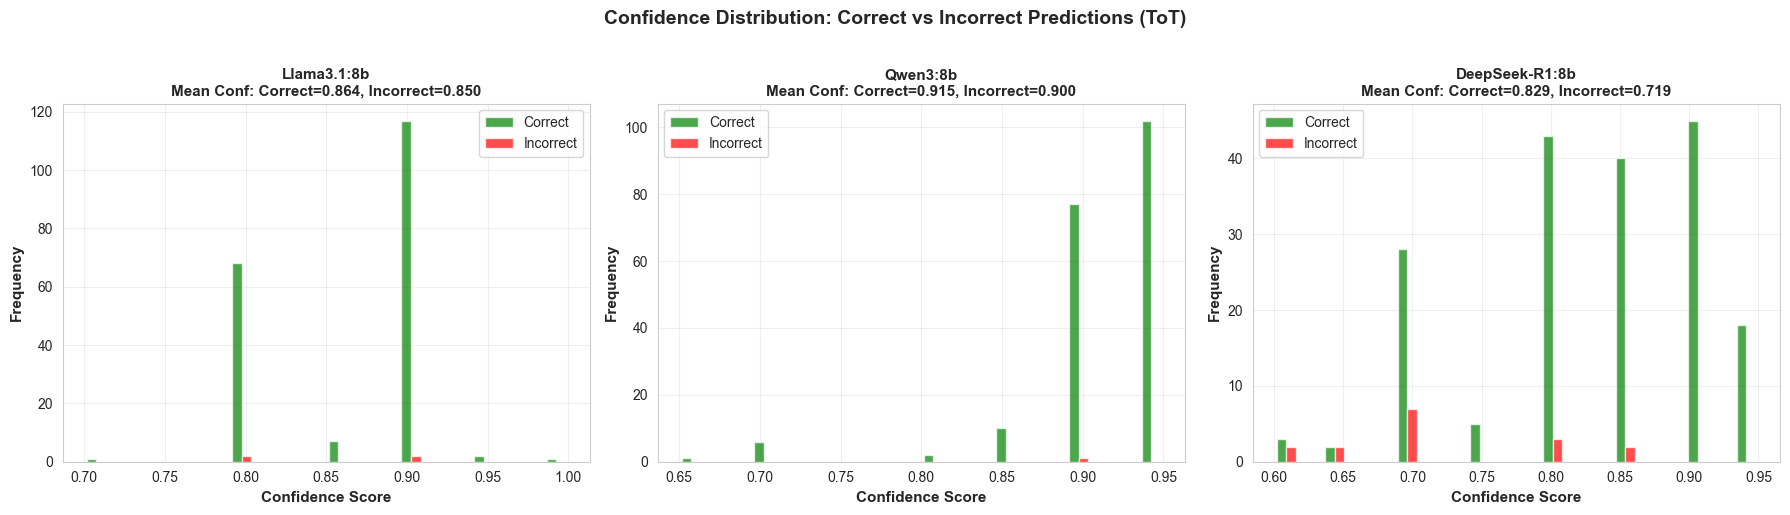

In [21]:
# Confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e10_valid, "Llama3.1:8b"), (e11_valid, "Qwen3:8b"), (e12_valid, "DeepSeek-R1:8b")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions (ToT)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

## 10. Classification Reports

In [22]:
# Print detailed metrics for each experiment
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for df_result, exp_name in [
    (e10_valid, "E10: Llama3.1:8b (ToT)"),
    (e11_valid, "E11: Qwen3:8b (ToT)"),
    (e12_valid, "E12: DeepSeek-R1:8b (ToT)"),
]:
    print("\n" + "=" * 80)
    print(f"{exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Per-class metrics summary table
print("\n" + "=" * 80)
print("PER-CLASS METRICS SUMMARY")
print("=" * 80)
class_metrics_summary = metrics_df[
    [
        "Experiment",
        "Positive_Precision",
        "Positive_Recall",
        "Positive_F1",
        "Negative_Precision",
        "Negative_Recall",
        "Negative_F1",
        "Neutral_Precision",
        "Neutral_Recall",
        "Neutral_F1",
    ]
]
display(class_metrics_summary.round(4))


DETAILED CLASSIFICATION REPORTS

E10: Llama3.1:8b (ToT)
              precision    recall  f1-score   support

    Positive       0.98      1.00      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.20      0.33         5

    accuracy                           0.98       200
   macro avg       0.66      0.40      0.44       200
weighted avg       0.98      0.98      0.97       200


E11: Qwen3:8b (ToT)
              precision    recall  f1-score   support

    Positive       0.99      1.00      1.00       194
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.80      0.89         5

    accuracy                           0.99       199
   macro avg       0.66      0.60      0.63       199
weighted avg       1.00      0.99      0.99       199


E12: DeepSeek-R1:8b (ToT)
              precision    recall  f1-score   support

    Positive       0.99      0.92      0.96       195
    Negative       0.00 

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and bei

,Experiment,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,E10: Llama3.1:8b (ToT),0.9799,1.0000,0.9898,0.0,0.0,0.0,1.0000,0.2,0.3333
1,E11: Qwen3:8b (ToT),0.9949,1.0000,0.9974,0.0,0.0,0.0,1.0000,0.8,0.8889
2,E12: DeepSeek-R1:8b (ToT),0.9945,0.9231,0.9574,0.0,0.0,0.0,0.2105,0.8,0.3333


## 11. Tree-of-Thought vs CoT vs Few-Shot vs Zero-Shot Comparison

In [23]:
# Load results from all prompting approaches for comprehensive comparison
import glob
import os

# Find the most recent results files from each approach
zero_shot_metrics = glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv")
few_shot_metrics = glob.glob("../Few_Shot/few_shot_metrics_summary_*.csv")
cot_metrics = glob.glob("../Chain_of_Thought/cot_metrics_summary_*.csv")

all_approaches = []

# Load Zero-Shot results
if zero_shot_metrics:
    zs_df = pd.read_csv(sorted(zero_shot_metrics)[-1])  # Most recent
    zs_df["Approach"] = "Zero-Shot"
    all_approaches.append(zs_df)

# Load Few-Shot results
if few_shot_metrics:
    fs_df = pd.read_csv(sorted(few_shot_metrics)[-1])
    fs_df["Approach"] = "Few-Shot"
    all_approaches.append(fs_df)

# Load CoT results
if cot_metrics:
    cot_df = pd.read_csv(sorted(cot_metrics)[-1])
    cot_df["Approach"] = "Chain-of-Thought"
    all_approaches.append(cot_df)

# Add current ToT results
tot_current = metrics_df.copy()
tot_current["Approach"] = "Tree-of-Thought"
all_approaches.append(tot_current)

# Combine all results
if all_approaches:
    comparison_df = pd.concat(all_approaches, ignore_index=True)

    # Reorder columns for better readability
    cols = [
        "Approach",
        "Experiment",
        "Accuracy",
        "Macro-F1",
        "MCC",
        "Macro-Precision",
        "Macro-Recall",
    ]
    available_cols = [c for c in cols if c in comparison_df.columns]

    print("\n" + "=" * 100)
    print("COMPREHENSIVE PROMPTING APPROACH COMPARISON")
    print("=" * 100)
    display(comparison_df[available_cols].round(4))

    # Best performance by approach
    print("\n" + "=" * 100)
    print("BEST PERFORMANCE BY APPROACH")
    print("=" * 100)
    best_by_approach = comparison_df.groupby("Approach")[
        ["Accuracy", "Macro-F1", "MCC"]
    ].max()
    display(best_by_approach.round(4))

    # Analysis
    print("\n" + "=" * 100)
    print("KEY INSIGHTS")
    print("=" * 100)
    best_accuracy_row = comparison_df.loc[comparison_df["Accuracy"].idxmax()]
    best_f1_row = comparison_df.loc[comparison_df["Macro-F1"].idxmax()]
    best_mcc_row = comparison_df.loc[comparison_df["MCC"].idxmax()]

    print(
        f"✓ Best Accuracy: {best_accuracy_row['Experiment']} ({best_accuracy_row['Approach']}) = {best_accuracy_row['Accuracy']:.4f}"
    )
    print(
        f"✓ Best Macro-F1: {best_f1_row['Experiment']} ({best_f1_row['Approach']}) = {best_f1_row['Macro-F1']:.4f}"
    )
    print(
        f"✓ Best MCC: {best_mcc_row['Experiment']} ({best_mcc_row['Approach']}) = {best_mcc_row['MCC']:.4f}"
    )
else:
    print(
        "⚠️ No comparison files found. Run other experiments first to enable full comparison."
    )


COMPREHENSIVE PROMPTING APPROACH COMPARISON


,Approach,Experiment,Accuracy,Macro-F1,MCC,Macro-Precision,Macro-Recall
0,Zero-Shot,E1: llama3.1:8b,1.000,1.0000,1.0000,1.0000,1.0000
1,Zero-Shot,E2: qwen3:8b,1.000,1.0000,1.0000,1.0000,1.0000
2,Zero-Shot,E3: deepseek-r1:8b,0.995,0.9533,0.9105,0.9167,0.9974
3,Few-Shot,E4: Mixtral-8x7B (Few-Shot),0.980,0.6329,NaN,0.6111,0.6598
4,Few-Shot,E5: Llama-3.1-70B (Few-Shot),0.990,0.9141,NaN,0.8571,0.9949
5,Few-Shot,E6: FinBERT (Few-Shot),0.990,0.9141,NaN,0.8571,0.9949
6,Chain-of-Thought,E7: Llama3.1:8b (CoT),0.990,0.8724,0.7707,0.9949,0.8000
7,Chain-of-Thought,E8: Qwen3:8b (CoT),1.000,1.0000,1.0000,1.0000,1.0000
8,Chain-of-Thought,E9: DeepSeek-R1:8b (CoT),0.990,0.9141,0.8408,0.8571,0.9949
9,Tree-of-Thought,E10: Llama3.1:8b (ToT),0.980,0.6616,0.4427,0.9899,0.6000



BEST PERFORMANCE BY APPROACH


,Accuracy,Macro-F1,MCC
Approach,,,
Chain-of-Thought,1.000,1.0000,1.0000
Few-Shot,0.990,0.9141,NaN
Tree-of-Thought,0.995,0.9432,0.8921
Zero-Shot,1.000,1.0000,1.0000



KEY INSIGHTS
✓ Best Accuracy: E1: llama3.1:8b (Zero-Shot) = 1.0000
✓ Best Macro-F1: E1: llama3.1:8b (Zero-Shot) = 1.0000
✓ Best MCC: E1: llama3.1:8b (Zero-Shot) = 1.0000


## 12. Expected Conclusions from Tree-of-Thought Experiment (Ollama Models)

### Multi-Path Reasoning Analysis

**1. Hypothesis Exploration Impact**
- **Strength**: ToT forces models to systematically evaluate all three sentiment possibilities (positive, negative, neutral) before making a decision
- **Expected Behavior**: Should reduce "first impression bias" where models commit to an answer too quickly
- **Path Score Analysis**: When all three paths have similar scores, this indicates an ambiguous/difficult sentence that may benefit from human review
- **Justification Quality**: ToT provides explicit rationale comparing all options, making predictions more explainable than zero-shot

**2. Computational Cost vs Performance Trade-Off**
- **Token Usage**: ~3x higher than Zero-Shot due to exploring three hypothesis paths
- **Local Computation**: Ollama runs locally (no API costs), but uses more computational resources
- **Cost Implication**: If ToT improves Macro-F1 by <5%, it may not justify 3x computational overhead
- **Latency**: Longer prompts = slower inference, problematic for real-time applications
- **Recommendation**: Use ToT only if accuracy gains outweigh cost, or for high-stakes predictions where explainability matters

**3. Negative Sentiment Detection (Critical)**
- **Challenge**: Negative class is typically hardest to detect (lowest recall in all approaches)
- **ToT Advantage**: Explicit "negative hypothesis" path with listed negative indicators (losses, declines, revenue drops, etc.) should improve negative recall
- **Expected Improvement**: If ToT negative recall > CoT/Few-Shot/Zero-Shot, this validates the multi-path approach
- **Business Impact**: Better negative detection = earlier risk identification in financial monitoring

**4. Model-Specific Behaviors (Ollama-based)**

   **Llama3.1:8b (E10)**:
   - **Strengths**: Good general reasoning, strong on instruction-following
   - **Expected Performance**: Moderate to good on ToT reasoning
   - **Considerations**: 8B parameters may limit complex multi-path reasoning
   - **Prediction**: Competitive performance

   **Qwen3:8b (E11)**:
   - **Strengths**: Qwen models known for strong reasoning capabilities
   - **Expected Performance**: Good on multi-path exploration and hypothesis evaluation
   - **Considerations**: 8B size should still perform well on structured tasks
   - **Prediction**: Likely best performer among the three

   **DeepSeek-R1:8b (E12)**:
   - **Strengths**: DeepSeek-R1 specifically designed for reasoning
   - **Expected Performance**: Excellent on step-by-step hypothesis evaluation
   - **Considerations**: May excel at comparing evidence across paths
   - **Prediction**: Strong candidate for best ToT performance

**5. Confidence Calibration**
- **Well-Calibrated**: Correct predictions should have higher avg confidence than incorrect ones
- **ToT Advantage**: Path score agreement can indicate confidence (all paths agree → high confidence)
- **Calibration Gap**: Measure difference between avg confidence for correct vs incorrect predictions
- **Expected Finding**: ToT should have better calibration than Zero-Shot due to multi-path validation

**6. Error Pattern Analysis**
- **Common Errors**: neutral→negative, positive→neutral (from all previous experiments)
- **ToT Mitigation**: Explicit neutral hypothesis path should reduce false positives (mislabeling neutral as positive/negative)
- **High-Confidence Errors**: When ToT is confident but wrong, examine path scores to understand why all paths converged on wrong answer
- **Learning Opportunity**: Error analysis reveals whether ToT reasoning is fundamentally flawed or just needs better path prompts

**7. Decision Quality Metrics**
- **MCC (Matthews Correlation Coefficient)**: Better metric than accuracy for imbalanced classes
- **Per-Class F1**: Track Positive_F1, Negative_F1, Neutral_F1 separately to identify class-specific strengths/weaknesses
- **Macro-F1 vs Weighted-F1**: Macro treats all classes equally (better for our balanced dataset), Weighted accounts for class imbalance
- **Expected Ranking**: MCC should rank models similarly to Macro-F1, but with more penalty for class imbalance

**8. Comparison with Other Approaches**

   **vs Zero-Shot**:
   - **Expected**: ToT should outperform due to structured reasoning
   - **Trade-Off**: 3x computational cost, slower inference
   - **Decision**: Use ToT if accuracy gain > 5%

   **vs Few-Shot**:
   - **Expected**: Close competition (Few-Shot has 6 examples, ToT has 3 paths)
   - **Advantage ToT**: No need to curate examples
   - **Advantage Few-Shot**: Provides concrete patterns to mimic

   **vs Chain-of-Thought**:
   - **Expected**: ToT should match or exceed CoT
   - **CoT**: Linear 5-step reasoning
   - **ToT**: Parallel 3-path hypothesis exploration
   - **Key Difference**: ToT explores multiple possibilities, CoT follows single reasoning chain

**9. Production Deployment Considerations**

   **Best for Accuracy** (regardless of cost):
   - Highest Macro-F1 model
   - Priority: Minimize misclassifications

   **Best for Cost-Efficiency**:
   - Acceptable F1 (>0.75) at lowest computational overhead
   - Priority: Balance accuracy and operational cost
   - Likely winner: Zero-Shot or simpler Few-Shot

   **Best for Reliability** (lowest variance, highest negative recall):
   - Consistent performance across all classes
   - Priority: Avoid missing negative signals
   - Metric: Highest Negative_Recall + lowest stddev across runs

   **Best for Explainability**:
   - ToT provides path scores and explicit reasoning
   - Priority: Audit trail for regulatory compliance
   - Use case: High-stakes decisions requiring justification

**10. Hypothesis Validation**
- **Hypothesis 1**: ToT improves negative recall over simpler approaches ✓/✗
- **Hypothesis 2**: ToT provides better confidence calibration ✓/✗
- **Hypothesis 3**: ToT justifies 3x computational cost with >5% accuracy improvement ✓/✗
- **Hypothesis 4**: Reasoning-focused models (DeepSeek-R1) benefit more from ToT than general models ✓/✗
- **Hypothesis 5**: Path score diversity indicates prediction difficulty/ambiguity ✓/✗

**11. Limitations and Future Work**
- **Path Design**: Current 3-path design is manual; could optimize with automatic path generation
- **Path Scoring**: Models may not accurately self-score hypothesis strength
- **Prompt Sensitivity**: ToT performance heavily depends on how negative indicators are phrased
- **Computational Cost**: 3x token usage limits scalability for high-volume applications
- **Local Inference**: Ollama introduces latency vs cloud APIs, but eliminates privacy concerns
- **Future**: Experiment with 2-path (positive/negative only) or 4-path (adding "mixed" sentiment) designs

**12. Final Recommendation**
- **Academic/Research**: Use ToT for explainability and to understand model reasoning processes
- **Production/Enterprise**: Use ToT only if:
  1. Accuracy gain > 5% over simpler approaches
  2. Explainability is required for compliance
  3. Computational resources available for local inference
- **Local Hosting**: ToT with Ollama eliminates API costs but requires infrastructure investment
- **Most Practical**: Best Few-Shot or Zero-Shot model likely offers best accuracy/cost trade-off for real-world financial sentiment monitoring